In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras import layers
from tensorflow import convert_to_tensor
sns.set_style("whitegrid")

2024-05-27 11:00:40.584783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 11:00:40.802505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
aggregate=pd.read_csv('./aggregate.csv',engine='python')
aggregate.set_index('GEO_ID',inplace=True)
agg_train, agg_test = train_test_split(aggregate,test_size=0.2,shuffle=True,random_state=121)
agg_train['unemp_bac']=agg_train['unemp_rate']*agg_train['bac_deg']
agg_train['log_pop']=np.log10(agg_train['total_pop'].apply(lambda x: max(x,0.1)))
agg_train['log_urban_pop']=np.log10((agg_train['urban']*agg_train['total_pop']).apply(lambda x: max(x,0.1)))
for x in agg_train.index:
    agg_train.loc[x,'winner'] = 'D' if agg_train.loc[x,'democrat'] > agg_train.loc[x,'republican'] else 'R'
features=['white_pc','log_pop','log_urban_pop','urban', 'unemp_bac', 'pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc']
results=['democrat','republican']
target='democrat'

In [56]:
kfold=KFold(n_splits=5,shuffle=True,random_state=121)
mse=0
for train_i, test_i in kfold.split(agg_train):
    train_var = agg_train.iloc[train_i]
    test_var = agg_train.iloc[test_i]
    x_tt=convert_to_tensor(train_var[features])
    y_tt=convert_to_tensor(train_var[target])
    x_test=convert_to_tensor(test_var[features])
    y_test=convert_to_tensor(test_var[target])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, #initial learning rate
    decay_steps= 1000 , # After 1000 steps we start to decrease the learning rate
    decay_rate=0.95, # multiply learning rate by 0.95 for each epoch after
    staircase=True)

    model = keras.Sequential([
    layers.InputLayer(len(features)),
    layers.BatchNormalization(axis = -1),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(1,kernel_regularizer=keras.regularizers.L2(0.01))
    ])
    #kernel_regularizer=keras.regularizers.L2(0.01)
    model.compile(keras.optimizers.legacy.Adam(learning_rate=lr_schedule), loss = "mse", metrics= [keras.metrics.RootMeanSquaredError()])
    history = model.fit(x_tt, y_tt, epochs = 200, validation_data = (x_test, y_test), batch_size = 32) 
    mse+=mean_squared_error(model.predict(x_test), y_test)
mse=mse/5

Epoch 1/200
63/63 [==============================] - 1s 4ms/step - loss: 489.9314 - root_mean_squared_error: 22.1338 - val_loss: 1396.7513 - val_root_mean_squared_error: 37.3727
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 110.4940 - root_mean_squared_error: 10.5102 - val_loss: 631.3184 - val_root_mean_squared_error: 25.1255
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 98.5233 - root_mean_squared_error: 9.9245 - val_loss: 176.4216 - val_root_mean_squared_error: 13.2813
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 96.4021 - root_mean_squared_error: 9.8170 - val_loss: 85.7504 - val_root_mean_squared_error: 9.2587
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 95.4939 - root_mean_squared_error: 9.7707 - val_loss: 76.9935 - val_root_mean_squared_error: 8.7730
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 84.2373 - root_mean_squared_error: 9.1766 - val_los

In [57]:

print(mse)

71.1614081338126


16/16 [==============================] - 0s 1ms/step


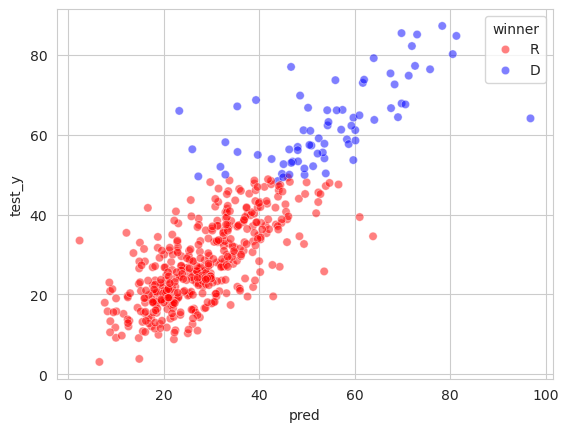

In [59]:
pred=pd.DataFrame({'pred':model.predict(test_var[features]).flatten(),'test_y':test_var['democrat'].values,'winner':test_var['winner'].values})
sns.scatterplot(data=pred,x='pred',y='test_y',hue='winner',palette=['red','blue'], alpha=0.5)
plt.show()